In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import optimizer
import sinkhorn_ops
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment
from tensorflow import keras
%matplotlib inline


In [2]:
#Define some ad-hoc merging, splitting and mixing functions


def batch_split(batch, n_squares_side, n_channels=1):
    if(n_channels ==1):
        side = int(np.sqrt(batch.shape[1]))
    else:
        side = batch.shape[1]
    batch_size = batch.shape[0]
    n_squares = n_squares_side ** 2
    
    batch = np.reshape(batch, [-1, side, side, n_channels])
    batch = np.reshape(batch, [batch_size, n_squares_side, side/n_squares_side, side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    batch = np.reshape(batch, [batch_size, side/n_squares_side, n_squares, side/n_squares_side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    return batch

def stack_batch_split(batch):
    return np.reshape(batch, [batch.shape[0]*batch.shape[1], batch.shape[2], batch.shape[3], batch.shape[4]])


def unflatten_batch(batch, n_channels=1):
    print(np.sqrt(batch.shape[2]/n_channels))
    side_square = int(np.sqrt(batch.shape[2]/n_channels))
    return np.reshape(batch, [batch.shape[0], batch.shape[1], side_square, side_square, n_channels])

def join_batch_split(batch):
    batch_size = batch.shape[0]
    n_squares = batch.shape[1]
    side_quare = batch.shape[2]
    n_channels = batch.shape[4]
    n_squares_side = int(np.sqrt(n_squares))
    batch = np.transpose(batch, [0, 1, 3, 2, 4])
    batch = np.reshape(batch, [batch_size, n_squares_side, side_square*n_squares_side, side_square, n_channels])
    batch = np.transpose(batch, [0,1, 3,2,4])
    batch = np.reshape(batch, [batch_size, 1, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    batch = np.reshape(batch, [batch_size, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    return batch

def resized_dims(n_squares_side):
    if(n_squares_side==2):
        side = 28
        side_square = 14
    if(n_squares_side==3):
        side = 27
        side_square = 9
    if(n_squares_side==4):
        side = 28
        side_square = 7
    if(n_squares_side==5):
        side = 30
        side_square = 6
    if(n_squares_side==6):
        side = 30
        side_square = 5
    if(n_squares_side==7):
        side = 28
        side_square = 4
    if(n_squares_side==8):
        side = 32
        side_square = 4
    if(n_squares_side==9):
        side = 27
        side_square = 3
    if(n_squares_side==16):
        side = 32
        side_square = 2
    return side, side_square

def resize_batch_color(batch, side_new, n_channels):
    batch_new = np.zeros((batch.shape[0], side_new, side_new, n_channels))
    side = int(np.sqrt(batch.shape[1]))
    for i in range(batch.shape[0]):
        for c in range(n_channels):
            a = imresize(batch[i,:,:,c], [side_new, side_new])
            
            a = a/255.0
            batch_new[i,:,:,c] =a
    return batch_new


def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


In [3]:
#Define model params
batch_size = 50
n_iter =1000
samples_per_num = 1
n_iter_sinkhorn = 20
noise_factor = 1.0
keep_prob =1.0
opt = 'sgd'
n_units = 4
temp = 0.00000000025
lr = 0.00001

#mnist data
rfield_size = 3
n_squares_side = 16
n_channels = 3
stride = 2
n_squares = n_squares_side **2
n_dim = 20
side, side_square = resized_dims(n_squares_side)


In [4]:
#Main neural network definitions

def create_log_alpha():
    #create the matrix of log_alpha, that will later will converted into a soft permutation
    #this relies on some NN processing (convolutional), see below
    fc = tf.contrib.layers.fully_connected
    flatten = tf.contrib.layers.flatten
    dropout = tf.contrib.layers.dropout
    def conv(input_image, kernel_shape, bias_shape):
        weights = tf.get_variable("weights", kernel_shape,
                                 initializer = tf.random_normal_initializer())
        biases = tf.get_variable("biases", bias_shape, 
                                initializer=tf.constant_initializer(0.0))
        convolutional = tf.nn.conv2d(input_image, weights, 
                                     strides = [1, 1, 1, 1],
                                     padding="SAME")
        out_relu = tf.nn.relu(convolutional + biases)
        out_maxpool = tf.nn.max_pool(out_relu, 
                                    ksize=[1, stride, stride, 1],
                                   strides=[1, stride, stride, 1],
                                   padding="SAME")
        return out_maxpool
    def conv_and_fc(input_image):
        with tf.variable_scope("conv1"):
            conv_output = conv(input_image, [rfield_size, rfield_size, n_channels, n_units], [n_units])
        fully_connected_output = dropout(tf.cast(fc(flatten(conv_output), n_dim, activation_fn = None), tf.float32),
                                        keep_prob)
        return fully_connected_output
    
    with tf.variable_scope("model_params"):
        log_alpha = tf.nn.sigmoid(tf.reshape(conv_and_fc(stack_scrambled_images_split), [-1, n_squares, n_dim]))
        #log_alpha = tf.reshape(conv_and_fc(stack_scrambled_images_split), [-1, n_squares, n_dim])
        
        sq = tf.reduce_sum(log_alpha **2, axis=2, keepdims=True)
        A = tf.tile(sq, [1, 1, n_squares])
        B = tf.tile(tf.transpose(sq, [0,2 ,1]), [1, n_squares, 1])
        C = -2*tf.matmul(log_alpha, tf.transpose(log_alpha, [0, 2, 1]))
        s1 = A+B +C
    with tf.variable_scope("model_params", reuse=True):    
        log_alpha2 = tf.nn.sigmoid(tf.reshape(conv_and_fc(stack_real_images_split), [-1, n_squares, n_dim]))
        #log_alpha2 = tf.reshape(conv_and_fc(stack_real_images_split), [-1, n_squares, n_dim])
        sq2 = tf.reduce_sum(log_alpha2 **2, axis=2, keepdims=True)
        A2 = tf.tile(sq2, [1, 1, n_squares])
        B2 = tf.tile(tf.transpose(sq2, [0,2 ,1]), [1, n_squares, 1])
        C2 = tf.matmul(-2*log_alpha2, tf.transpose(log_alpha2, [0, 2, 1]))
        s2 = A2+B2 +C2
        
    return s1,s2

In [5]:
#Now we define the main TF variables

scrambled_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, n_channels])
scrambled_split_tiled = tf.tile(scrambled_split, [samples_per_num, 1, 1, 1, 1])

stack_scrambled_images_split = tf.placeholder(tf.float32,[None, side_square, side_square, n_channels])

real_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, n_channels])
real_split_tiled = tf.tile(real_split, [samples_per_num, 1, 1, 1, 1])

stack_real_images_split = tf.placeholder(tf.float32,[None, side_square, side_square, n_channels])


temperature = tf.constant(temp, dtype=tf.float32)
global_step = tf.Variable(0, trainable=False)
fc = tf.contrib.layers.fully_connected

s1,s2 = create_log_alpha()
f1 = tf.tile(tf.reduce_sum(s1**2, axis=2, keepdims=True),[1, 1, n_squares]) 
f2 = tf.transpose(tf.tile(tf.reduce_sum(s2**2, axis=2, keepdims=True),[1, 1, n_squares]), [0, 2 ,1]) 
soft_perms_inf = tf.cast(tf.tile(tf.constant(np.eye(n_squares))[np.newaxis,:,:],[batch_size, 1, 1]), tf.float32)
          
for _ in range(5):
    P = tf.reshape(soft_perms_inf, [-1, n_squares, n_squares])      
    ma = -1*(f1+f2 - 2*tf.matmul(s1, tf.matmul(P, s2)))
    (soft_perms_inf, _) = sinkhorn_ops.gumbel_sinkhorn(ma, temp, samples_per_num,
                                                                       noise_factor, n_iter_sinkhorn, squeeze=False)

P = tf.reshape(soft_perms_inf, [-1, n_squares, n_squares])
l2s_diff = tf.reduce_sum(tf.matmul(P, -ma))   

soft_perms_inf1 = tf.cast(tf.tile(tf.constant(np.eye(n_squares))[np.newaxis,:,:],[batch_size, 1, 1]), tf.float32)
P1 = tf.reshape(soft_perms_inf1, [-1, n_squares, n_squares])      
ma1= -1*(f1+f2 - 2*tf.matmul(s1, tf.matmul(P1, s2)))
(soft_perms_inf1, _) = sinkhorn_ops.gumbel_sinkhorn(ma1, temp, samples_per_num,
                                                                   noise_factor, n_iter_sinkhorn, squeeze=False)



inv_soft_perms = tf.transpose(soft_perms_inf, [0, 1, 3, 2])
inv_soft_perms_flat = tf.reshape( tf.transpose(inv_soft_perms, [1, 0, 2, 3]), [-1, n_squares, n_squares])

real_split_tiled = tf.reshape(real_split_tiled, [-1, n_squares, side_square ** 2 * n_channels])
scrambled_split_tiled = tf.reshape(scrambled_split_tiled, [-1, n_squares, side_square ** 2* n_channels])
ordered_inf = tf.matmul(inv_soft_perms_flat, scrambled_split_tiled)
l2s_diff = tf.reduce_mean(tf.square(real_split_tiled - ordered_inf))
opt = optimizer.set_optimizer(opt, lr, opt_eps=1e-8)
train_op = tf.contrib.training.create_train_op(l2s_diff, opt, global_step=global_step)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [6]:
#Lets train the model
train,test= tf.keras.datasets.cifar10.load_data()

init_op=tf.initialize_all_variables()
sess=tf.InteractiveSession()
sess.run(init_op)

for i in range(n_iter):
    batch = np.random.choice(train[0].shape[0],batch_size,replace=False)
    np_x = train[0][batch,:,:,:]
    np_x = resize_batch_color(np_x, side, n_channels)
   
    batch = np.random.choice(train[0].shape[0],batch_size,replace=False)
    np_x2 = train[0][batch,:,:,:]
    np_x2 = resize_batch_color(np_x2, side, n_channels)
   
    real_images_split = batch_split(np_x, n_squares_side, n_channels)
    real_images_split2 = batch_split(np_x2, n_squares_side, n_channels)
    
    scrambled_images_split = np.zeros(real_images_split.shape)
    
    for j in range(batch_size):
        perm = np.random.permutation(n_squares)
        scrambled_images_split[j,:, :, :] = real_images_split2[j, perm, :, :]
    stacked_scrambled_images_split = stack_batch_split(scrambled_images_split)
    stacked_real_images_split = stack_batch_split(real_images_split)
    _,loss=sess.run([train_op,l2s_diff],{real_split:real_images_split,
                                         scrambled_split:scrambled_images_split,
                                        stack_scrambled_images_split:stacked_scrambled_images_split,
                                        stack_real_images_split:stacked_real_images_split})
    
   
    if i % 50 == 1:
        print('Step %d, Loss: %0.7f' % (i,loss))


Instructions for updating:
Use `tf.global_variables_initializer` instead.


/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Step 1, Loss: 0.1176302
Step 51, Loss: 0.1024049
Step 101, Loss: 0.1195201
Step 151, Loss: 0.0825512
Step 201, Loss: 0.0920692
Step 251, Loss: 0.1040788
Step 301, Loss: 0.1028127
Step 351, Loss: 0.0989012
Step 401, Loss: 0.1064510
Step 451, Loss: 0.1281761
Step 501, Loss: 0.0975910
Step 551, Loss: 0.1053861
Step 601, Loss: 0.1093757
Step 651, Loss: 0.0842474
Step 701, Loss: 0.1169883
Step 751, Loss: 0.0884859
Step 801, Loss: 0.1017781
Step 851, Loss: 0.0880353
Step 901, Loss: 0.1263620
Step 951, Loss: 0.1170183


In [41]:
#Now let's test the model
#np.random.seed(0)
#tf.random.set_random_seed(0)
batch_size_test=batch_size
batch = np.random.choice(test[0].shape[0],batch_size,replace=False)
np_x = test[0][batch,:,:,:]
np_x = resize_batch_color(np_x, side, n_channels)


/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [45]:

batch = np.random.choice(test[0].shape[0],batch_size,replace=False)
np_x2 = test[0][batch,:,:,:]
np_x2 = resize_batch_color(np_x2, side, n_channels)

real_images_split = batch_split(np_x, n_squares_side, n_channels)
#p = 0.2
#real_images_split = np.tile(np.random.binomial(1,p,[50,196,1,1,1]), [1,1,2,2,1])
real_images_split2 = batch_split(np_x2, n_squares_side, n_channels)

scrambled_images_split = np.zeros(real_images_split.shape)
    
for i in range(batch_size_test):
    perm = np.random.permutation(n_squares)
    scrambled_images_split[i,:, :, :] = real_images_split[i, perm, :, :]
stacked_scrambled_images_split = stack_batch_split(scrambled_images_split)
stacked_real_images_split = stack_batch_split(real_images_split2)
[unscrambled_images,loss, inv_soft_perms_np,ma_np,s1_np,s2_np,soft_inv2] = sess.run([ordered_inf,
                                                                           l2s_diff,
                                                                           inv_soft_perms,
                                                                           ma,s1,s2,soft_perms_inf1],
                                                                          {real_split:real_images_split2,
                            scrambled_split:scrambled_images_split,
                            stack_scrambled_images_split:stacked_scrambled_images_split,
                                                                           stack_real_images_split:stacked_real_images_split})


/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


2.0


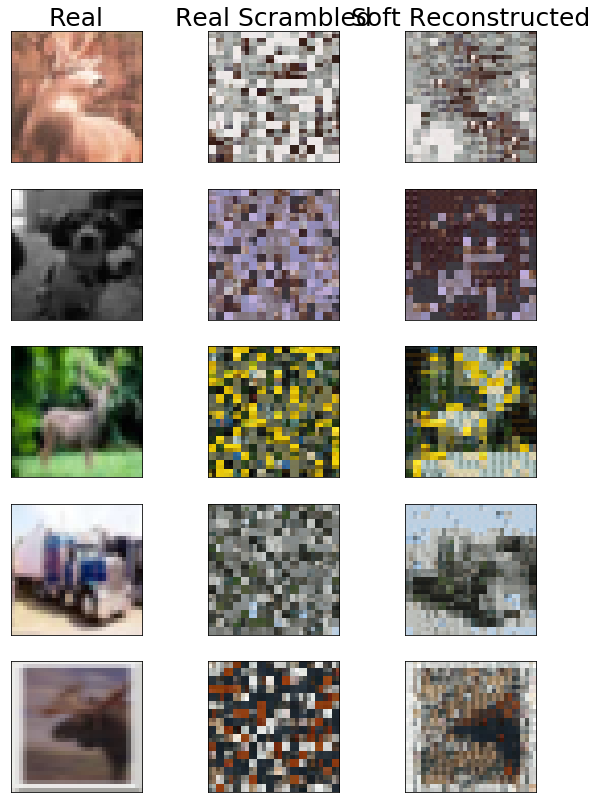

In [46]:
batch_size_display = 5
unscrambled_images = unscrambled_images[:batch_size_display,:,:]
inv_hard_perms= np.zeros((batch_size_display, n_squares, n_squares))
for i in range(batch_size_display):
    inv_hard_perms[i,:,:] = soft_to_hard(inv_soft_perms_np[i,0,:,:])
    inv_hard_perms[i,:,:] = soft_inv2[i,0,:,:].T
unflatten_inf = unflatten_batch(unscrambled_images, n_channels)
hard_inf = np.matmul(inv_hard_perms, np.reshape(scrambled_images_split[:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))

unflatten_hard_inf =np.reshape(hard_inf, unflatten_inf.shape)
joined_hard_inf =join_batch_split(unflatten_hard_inf)
joined_inf = join_batch_split(unflatten_inf)
joined_scrambled = join_batch_split(scrambled_images_split)
joined_real = join_batch_split(real_images_split2)

#Compare reconstructions with real data

fig, ax = plt.subplots(batch_size_display,3,figsize=(10,14))

for i in range(batch_size_display):
   
    ax[i,0].imshow(joined_real[i,:,:,:],cmap='Greys')
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    ax[i,1].imshow(joined_scrambled[i,:,:,:],cmap='Greys')
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
    
    ax[i,2].imshow(joined_inf[i,:,:,:],cmap='Greys')
    ax[i,2].get_xaxis().set_visible(False)
    ax[i,2].get_yaxis().set_visible(False)
     
#     ax[i,3].imshow(joined_hard_inf[i,:,:,:],cmap='Greys')
#     ax[i,3].get_xaxis().set_visible(False)
#     ax[i,3].get_yaxis().set_visible(False)
   

    if(i==0):
        ax[i,0].set_title('Real',fontsize =25)
        ax[i,1].set_title('Real Scrambled',fontsize =25)
        ax[i,2].set_title('Soft Reconstructed',fontsize =25)
        #ax[i,3].set_title('Hard Reconstructed',fontsize =25)
plt.savefig('reconstruct2.png')

(50, 1, 256, 256)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

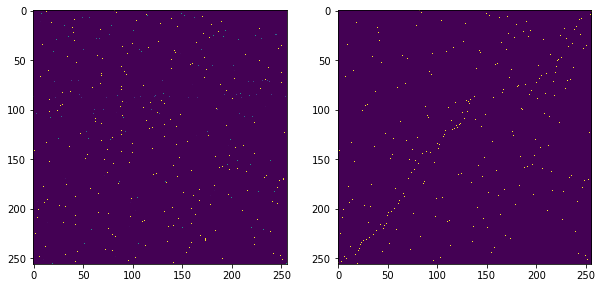

In [8]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(inv_soft_perms_np⎄=[0,0,:,:])
ax[1].imshow(inv_hard_perms[0,:,:])
print(inv_soft_perms_np.shape)
print(inv_soft_perms_np[0,0,0,:])
print(inv_hard_perms[0,0,:])
print(np.nansum(inv_soft_perms_np[0,0,:,:],axis=0))

(50, 256, 2, 2, 3)


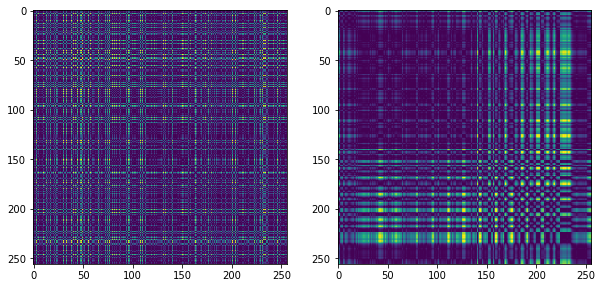

In [9]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(s1_np[2,:,:])
ax[1].imshow(s2_np[2,:,:])
print(real_images_split.shape)

In [10]:
print(real_images_split.shape)

(50, 256, 2, 2, 3)


In [11]:
np.random.binomial(np.random.binomial(1,p,[50,196,1,1,1]),)

NameError: name 'p' is not defined